In [1]:
import optuna
import numpy as np

from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, log_loss, precision_recall_curve, auc, roc_auc_score, confusion_matrix, precision_score, f1_score, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score

/Users/sgroote/tf-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_auc_roc_pr_metrics(y_true: np.ndarray, y_pred: np.ndarray, num_thresholds: int = 100):
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision = np.zeros(num_thresholds)
    recall = np.zeros(num_thresholds)
    fpr = np.zeros(num_thresholds)
    tpr = np.zeros(num_thresholds)

    for i, t in enumerate(thresholds):
        y_pred_bin = (y_pred >= t).astype(int)

        TP = np.sum((y_true == 1) & (y_pred_bin == 1))
        FP = np.sum((y_true == 0) & (y_pred_bin == 1))
        FN = np.sum((y_true == 1) & (y_pred_bin == 0))
        TN = np.sum((y_true == 0) & (y_pred_bin == 0))

        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        fpr[i] = FP / (FP + TN) if (FP + TN) > 0 else 0.0
        tpr[i] = recall[i]  # TPR is the same as recall

    return precision, recall, fpr, tpr

# Helper functions
def compute_metrics(true_vals_binary, pred_probabilities, threshold=0.5):
    """Compute all classification metrics."""
    binary_preds = (pred_probabilities > threshold).astype(int)
    cm = confusion_matrix(true_vals_binary, binary_preds)
    
    TN = FP = FN = TP = -1
    if cm.shape == (2,2):
        TN, FP, FN, TP = cm.ravel()
    
    acc = accuracy_score(true_vals_binary, binary_preds)
    mcc = matthews_corrcoef(true_vals_binary, binary_preds)
    cohens_kappa_gt = cohen_kappa_score(true_vals_binary, binary_preds)
    roc_auc = roc_auc_score(true_vals_binary, pred_probabilities)
    
    precision_precise, recall_precise, _ = precision_recall_curve(true_vals_binary, pred_probabilities)
    pr_auc = auc(recall_precise, precision_precise)
    
    precision_100, recall_100, fpr_100, tpr_100 = compute_auc_roc_pr_metrics(true_vals_binary, pred_probabilities, num_thresholds=100)
    
    return {
        "accuracy": acc,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "TP": TP,
        "Precision (100 thresholds)": precision_100,
        "Recall (100 thresholds)": recall_100,
        "FPR (100 thresholds)": fpr_100,
        "TPR (100 thresholds)": tpr_100,
        "mcc": mcc,
        "cohens_kappa_gt": cohens_kappa_gt,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

def compute_metrics_small(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "log_loss": log_loss(y_true, y_prob),
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),          # sensitivity
        "specificity": tn / (tn + fp) if (tn + fp) > 0 else 0.0,
        "roc_auc": roc_auc_score(y_true, y_prob)
    }

def find_best_threshold(y_true, y_pred_probs, metric='accuracy', num_thresholds=101):
    thresholds = np.linspace(0, 1, num_thresholds)
    best_thresh = 0.5
    best_score = -np.inf
    
    for t in thresholds:
        y_pred_bin = (y_pred_probs >= t).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred_bin)
        elif metric == 'accuracy':
            score = accuracy_score(y_true, y_pred_bin)
        elif metric == 'mcc':
            score = matthews_corrcoef(y_true, y_pred_bin)
        else:
            raise ValueError(f"Unsupported metric: {metric}")
        
        if score > best_score:
            best_score = score
            best_thresh = t
            
    return best_thresh, best_score

In [22]:
def concat_second_dim(arrays):
    return np.concatenate(arrays, axis=1)
    
def concat_at_dim_except(arrays, skip_idx, dim=1):
    return np.concatenate(
        [arr for i, arr in enumerate(arrays) if i != skip_idx],
        axis=dim
    )


arrays = np.array([ # Folds
    [               # Models
        [1, 0],     # Data points
        [0, 1],
        [1, 1],
    ],
    [
        [1, 1],
        [1, 0],
        [0, 0],
    ],
    [
        [0, 0],
        [1, 1],
        [0, 1]
    ]
])

print(concat_second_dim(arrays))
print(concat_second_dim_except(arrays, 1))

[[1 0 1 1 0 0]
 [0 1 1 0 1 1]
 [1 1 0 0 0 1]]
[[1 0 0 0]
 [0 1 1 1]
 [1 1 0 1]]


In [54]:
# Load predictions from training
path_to_predictions_final = "./results/training_run_20251217_224656_FINAL"
path_to_predictions =  "./results/training_run_20251217_224656"
ground_truth_path = "./training_data/ground_truth.npz"

seed = 43 # SAME AS WITH TRAINING: VERY IMPORTANT

preprocessing_names = [
    "normal", "CLAHE", "gray", "gray_CLAHE", "edges"
]
cropping_names = [
    "full", "hm", "vert", "od"
]

identifiers = [f"{processing}_{crop}" for processing in preprocessing_names for crop in cropping_names ]
print(identifiers)
prediction_sets_validation_final = []
prediction_sets_test_final = []

# Loading prediction sets from file
for ident in identifiers:
    prediction_path = f"{path_to_predictions_final}/{ident}/val_preds_fold_-1.npz"
    current_pred_set = np.load(prediction_path)
    prediction_sets_validation_final.append(current_pred_set["y_hat_val"])
    prediction_sets_test_final.append(current_pred_set["y_hat_test"])

assert len(prediction_sets_validation_final) == len(prediction_sets_test_final), "There should be an equal number of validation and test sets"

prediction_sets_validation = []
prediction_sets_test = []
for fold in range(10):
    curr_fold_val = []
    curr_fold_test = []
    for ident in identifiers:
        prediction_path = f"{path_to_predictions}/{ident}/val_preds_fold_{fold}.npz"
        current_pred_set = np.load(prediction_path)
        curr_fold_val.append(current_pred_set["y_hat_val"])
        curr_fold_test.append(current_pred_set["y_hat_test"])
        
    prediction_sets_validation.append(np.array(curr_fold_val))
    prediction_sets_test.append(np.array(curr_fold_test))
        
pred_sets_concatenated_validation = concat_second_dim(prediction_sets_validation)
print(pred_sets_concatenated_validation.shape)
# [[[1, 0], [1, 1], [0, 0]], [[1, 1], [0, 1], [0, 0]]
# [[1, 0, 1, 1], [1, 1, 0, 1], [0, 0, 0, 0]]

# Load ground truth
gt_dict = np.load(ground_truth_path)
y_full = gt_dict['y'].astype(int)

# Load pre-computed folds from file
fold_data = np.load("./training_data/data_split_indices.npz")

train_val_indices = fold_data['train_val_indices']
final_val_idx = fold_data['final_val_pos']
test_idx = fold_data['test_indices']

val_idx_list = [fold_data['fold_val_indices'][fold] for fold in range(10)]
val_idx_concatenated = np.concatenate(val_idx_list)

print(np.array(val_idx_list).shape)

# Filter arrays according to folds
y_val_list = [y_full[val_idx] for val_idx in val_idx_list]
final_y_val = y_full[final_val_idx]
y_test = y_full[test_idx]

N = len(train_val_indices)
print(f"N = {N}, positives = {(y_full[train_val_indices]==1).sum()}, negatives = {(y_full[train_val_indices]==0).sum()}")


['normal_full', 'normal_hm', 'normal_vert', 'normal_od', 'CLAHE_full', 'CLAHE_hm', 'CLAHE_vert', 'CLAHE_od', 'gray_full', 'gray_hm', 'gray_vert', 'gray_od', 'gray_CLAHE_full', 'gray_CLAHE_hm', 'gray_CLAHE_vert', 'gray_CLAHE_od', 'edges_full', 'edges_hm', 'edges_vert', 'edges_od']
(20, 1130)
(10, 113)
N = 1130, positives = 565, negatives = 565


In [67]:


names = [
    'normal_full', 'normal_hm', 'normal_vert', 'normal_od',
    'CLAHE_full', 'CLAHE_hm', 'CLAHE_vert', 'CLAHE_od',
    'gray_full', 'gray_hm', 'gray_vert', 'gray_od',
    'gray_CLAHE_full', 'gray_CLAHE_hm', 'gray_CLAHE_vert', 'gray_CLAHE_od',
    'edges_full', 'edges_hm', 'edges_vert', 'edges_od'
]

print(rename_configs(names))


['Normal / Full', 'Normal / Temporal', 'Normal / Vertical', 'Normal / OD', 'CLAHE / Full', 'CLAHE / Temporal', 'CLAHE / Vertical', 'CLAHE / OD', 'Gray / Full', 'Gray / Temporal', 'Gray / Vertical', 'Gray / OD', 'Gray_CLAHE / Full', 'Gray_CLAHE / Temporal', 'Gray_CLAHE / Vertical', 'Gray_CLAHE / OD', 'Edges / Full', 'Edges / Temporal', 'Edges / Vertical', 'Edges / OD']


In [58]:
import numpy as np
import optuna
import logging

def optimize_weighted_ensemble(
    prediction_sets,          # np array (n_models, n_samples)
    y_true,                   # ground truth (n_samples,)
    opt_indices,              # indices into y_true
    val_set=None,    # (prediction_set, y_true)
    test_set=None,            # (prediction_set, y_true)
    n_trials=500,
    sampler=None,
    pruner=None,
    metrics_to_track_per_trial = ["accuracy", "log_loss", "roc_auc"],
    mode="floating_point",     # "floating_point" or "binary"
    print_every=500,           # control printing frequency
):
    n_models = prediction_sets.shape[0]
    y_opt = y_true[opt_indices]

    # Convert to float32 to reduce memory/computation
    prediction_sets = prediction_sets.astype(np.float32)
    if test_set != None:
        test_set = (test_set[0].astype(np.float32), test_set[1])

    def ensemble_predictions(weights, predictions):
        return np.dot(weights, predictions)

    tracking = {
        # Best opt information
        "best_opt_loss": np.inf,
        "best_opt_weights": None,
        "best_opt_trial_number": None,

        # Best internal validation information
        "best_val_loss": np.inf,
        "best_val_weights": None,
        "best_val_trial_number": None,
        
        # Best test information
        "best_test_loss": np.inf,
        "best_test_weights": None,
        "best_test_trial_number": None,        
        
        # Track best metrics
        "best_opt_opt_metrics": [],
        "best_opt_test_metrics": [],
        "best_test_opt_metrics": [],
        "best_test_test_metrics": [],
        "best_val_val_metrics": [],
        "best_val_test_metrics": [],

        # Tracking
        "opt_metrics": {metric:[] for metric in metrics_to_track_per_trial},
        "test_metrics": {metric:[] for metric in metrics_to_track_per_trial},
        "val_metrics": {metric:[] for metric in metrics_to_track_per_trial},
    }

    def objective(trial):
        # ----- Weights -----
        if mode == "floating_point":
            raw_weights = np.array(
                [trial.suggest_float(f"w_{i}", -5.0, 5.0) for i in range(n_models)],
                dtype=np.float32,
            )
            weights = np.exp(raw_weights)
            weights /= weights.sum()
        
        elif mode == "binary":
            sampler = trial.study.sampler
        
            if isinstance(sampler, optuna.integration.PyCmaSampler):
                raw = np.array(
                    [trial.suggest_float(f"use_model_{i}", 0.0, 1.0)
                     for i in range(n_models)],
                    dtype=np.float32,
                )
                weights = (raw > 0.5).astype(np.float32)
        
            else:
                weights = np.array(
                    [trial.suggest_categorical(f"use_model_{i}", [0, 1])
                     for i in range(n_models)],
                    dtype=np.float32,
                )
        
            if weights.sum() == 0:
                raise optuna.TrialPruned()
        
            weights /= weights.sum()
        
        else:
            raise ValueError(f"Unknown mode: {mode}")

        # ----- Compute optimization loss -----
        opt_probs = ensemble_predictions(weights, prediction_sets)
        opt_metrics = compute_metrics_small(y_opt, opt_probs)
        opt_loss = opt_metrics["log_loss"]
        tracking["opt_metrics"]["log_loss"].append(opt_loss)
        tracking["opt_metrics"]["accuracy"].append(opt_metrics["accuracy"])
        tracking["opt_metrics"]["roc_auc"].append(opt_metrics["roc_auc"])

        # Evaluate val set
        if val_set != None:
            val_probs = ensemble_predictions(weights, val_set[0])
            val_metrics = compute_metrics_small(val_set[1], val_probs)
            tracking["val_metrics"]["log_loss"].append(val_metrics["log_loss"])
            tracking["val_metrics"]["accuracy"].append(val_metrics["accuracy"])
            tracking["val_metrics"]["roc_auc"].append(val_metrics["roc_auc"])
            
        # Evaluate test set
        test_probs = ensemble_predictions(weights, test_set[0])
        test_metrics = compute_metrics_small(test_set[1], test_probs)
        tracking["test_metrics"]["log_loss"].append(test_metrics["log_loss"])
        tracking["test_metrics"]["accuracy"].append(test_metrics["accuracy"])
        tracking["test_metrics"]["roc_auc"].append(test_metrics["roc_auc"])
        
        # Update best opt trial
        if opt_loss < tracking["best_opt_loss"]:
            tracking["best_opt_loss"] = opt_loss
            tracking["best_opt_weights"] = weights.copy()
            tracking["best_opt_opt_metrics"].append({'metrics':opt_metrics, 'trial_number':trial.number})
            tracking["best_opt_trial_number"] = trial.number
            tracking["best_opt_test_metrics"].append({'metrics': test_metrics, 'trial_number': trial.number})

        # Update best test trial: Used in analysis only during X-fold validation.
        if test_metrics["log_loss"] < tracking["best_test_loss"]:
            tracking["best_test_loss"] = test_metrics["log_loss"]
            tracking["best_test_weights"] = weights.copy()
            tracking["best_test_test_metrics"].append({'metrics':test_metrics, 'trial_number':trial.number})
            tracking["best_test_trial_number"] = trial.number
            tracking["best_test_opt_metrics"].append({'metrics': opt_metrics, 'trial_number': trial.number})
        
        if val_set != None and val_metrics["log_loss"] < tracking["best_val_loss"]:
            tracking["best_val_test_weights"] = weights.copy()
            tracking["best_val_loss"] = val_metrics["log_loss"]
            tracking["best_val_weights"] = weights.copy()
            tracking["best_val_test_metrics"].append({'metrics':test_metrics, 'trial_number':trial.number})
            tracking["best_val_trial_number"] = trial.number
            tracking["best_val_val_metrics"].append({'metrics': val_metrics, 'trial_number': trial.number})
            
        # Minimal progress print
        if trial.number % print_every == 0:
            print(
                f"[Trial {trial.number}] "
                f"val_loss={opt_loss:.4f}, "
                f"val_acc={opt_metrics['accuracy']:.4f}, "
                f"val_roc={opt_metrics['roc_auc']:.4f}"
            )

        # ----- Optuna pruning -----
        if trial.number % 100 == 0:
            trial.report(opt_loss, step=trial.number)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return opt_loss

    # ======================= Run Study =======================
    optuna.logging.set_verbosity(logging.ERROR)

    study = optuna.create_study(
        direction="minimize",
        sampler=sampler or optuna.samplers.TPESampler(),
        pruner=pruner or optuna.pruners.MedianPruner(),
        load_if_exists=True,
    )

    study.optimize(objective, n_trials=n_trials)

    return tracking, study


In [59]:
seed = 43
configs = {
    'Bayesian_Floating': {
        "trials":3000,
        "sampler":optuna.samplers.TPESampler(
            multivariate=True,
            n_startup_trials=100,
            seed=seed
        ),
        "mode":'floating_point',
    },
    'Bayesian_Binary': {
        "trials":3000,
        "sampler":optuna.samplers.TPESampler(
            multivariate=True,
            n_startup_trials=100,
            seed=seed
        ),
        "mode":'binary',
    },
    'Genetic_Floating': {
        "trials":1500,
        "sampler":optuna.integration.PyCmaSampler(
            n_startup_trials=100,
            seed=seed
        ),
        "mode":'floating_point',
    },
    'Genetic_Binary': {
        "trials":5000,
        "sampler":optuna.samplers.NSGAIISampler(
            seed=seed
        ),
        "mode":'binary',
    }
}

tracking_per_config = {}

for name, config in configs.items():
    print(f"Starting test optimization for {name}...")
    tracking, study = optimize_weighted_ensemble(
        prediction_sets=pred_sets_concatenated_validation,
        y_true=y_full,
        opt_indices=val_idx_concatenated,
        val_set=(np.array(prediction_sets_validation_final), final_y_val),
        test_set=(np.array(prediction_sets_test_final), y_test),
        n_trials=config['trials'],
        sampler=config['sampler'],
        mode=config['mode'],
        print_every=100,
    )
    tracking_per_config[name] = tracking
    
    # tracking_per_fold = []
    # for fold_idx in range(10):
    #     print(f"Starting optimization for {name} fold {fold_idx}...")
        
    #     tracking, study = optimize_weighted_ensemble(
    #         prediction_sets=concat_at_dim_except(prediction_sets_validation, fold_idx),
    #         y_true=y_full,
    #         opt_indices=concat_at_dim_except(val_idx_list, fold_idx, 0),
    #         test_set= (prediction_sets_validation[fold_idx], y_val_list[fold_idx]),
    #         n_trials=config['trials'],
    #         sampler=config['sampler'],
    #         mode=config['mode'],
    #         print_every=100,
    #     )
        
    #     tracking_per_fold.append(tracking)
        
    # tracking_per_config[name] = tracking_per_fold
    

/Users/sgroote/tf-venv/lib/python3.9/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Starting test optimization for Bayesian_Floating...
[Trial 0] val_loss=0.5730, val_acc=0.6850, val_roc=0.7654
[Trial 100] val_loss=0.5466, val_acc=0.7018, val_roc=0.7883
[Trial 200] val_loss=0.5611, val_acc=0.6867, val_roc=0.7733
[Trial 300] val_loss=0.5412, val_acc=0.6982, val_roc=0.7916
[Trial 400] val_loss=0.5330, val_acc=0.6991, val_roc=0.8017
[Trial 500] val_loss=0.5409, val_acc=0.7062, val_roc=0.7936
[Trial 600] val_loss=0.5249, val_acc=0.7080, val_roc=0.8016
[Trial 700] val_loss=0.5328, val_acc=0.6982, val_roc=0.7962
[Trial 800] val_loss=0.5293, val_acc=0.7097, val_roc=0.8039
[Trial 900] val_loss=0.5265, val_acc=0.7000, val_roc=0.7999
[Trial 1000] val_loss=0.5378, val_acc=0.7027, val_roc=0.7993
[Trial 1100] val_loss=0.5277, val_acc=0.7097, val_roc=0.8056
[Trial 1200] val_loss=0.5255, val_acc=0.7106, val_roc=0.8035
[Trial 1300] val_loss=0.5328, val_acc=0.7133, val_roc=0.8006
[Trial 1400] val_loss=0.5251, val_acc=0.7115, val_roc=0.8051
[Trial 1500] val_loss=0.5314, val_acc=0.7018,

In [60]:
import pickle

with open("cross_val_HPO_stats_3.pkl", "wb") as f:
    pickle.dump(tracking_per_config, f)

In [57]:
import pickle

with open("test_HPO_stats_2.pkl", "wb") as f:
    pickle.dump(tracking_per_config, f)

In [63]:
min_trials = {}

for label, config_key in [
    ("CME-ES Floating", "Genetic_Floating"),
    ("CME-ES Binary",   "Genetic_Binary"),
]:
    tracking_list = tracking_per_config[config_key]
    n_folds = len(tracking_list)

    # Collect all folds' val_hist
    val_arrays = [np.array(tracking["opt_metrics"]["log_loss"]) for tracking in tracking_list if len(tracking["opt_metrics"]["log_loss"]) > 0]

    if len(val_arrays) == 0:
        continue  # no valid folds

    # Determine the maximum trial index where all folds are still alive
    min_length = min(len(arr) for arr in val_arrays)
    if min_length == 0:
        continue

    # Stack arrays truncated to the shortest fold
    stacked = np.stack([arr[:min_length] for arr in val_arrays])  # shape: (folds, trials)

    # Mean across folds
    mean_per_trial = stacked.mean(axis=0)

    # Find trial with minimum mean
    min_idx = np.argmin(mean_per_trial)
    min_value = mean_per_trial[min_idx]

    min_trials[label] = (min_idx, min_value)

# Display results
for label, (trial, value) in min_trials.items():
    print(f"{label}: minimum mean log-loss = {value:.5f} at trial {trial}")


CME-ES Floating: minimum mean log-loss = 0.50599 at trial 1464
CME-ES Binary: minimum mean log-loss = 0.50825 at trial 1142


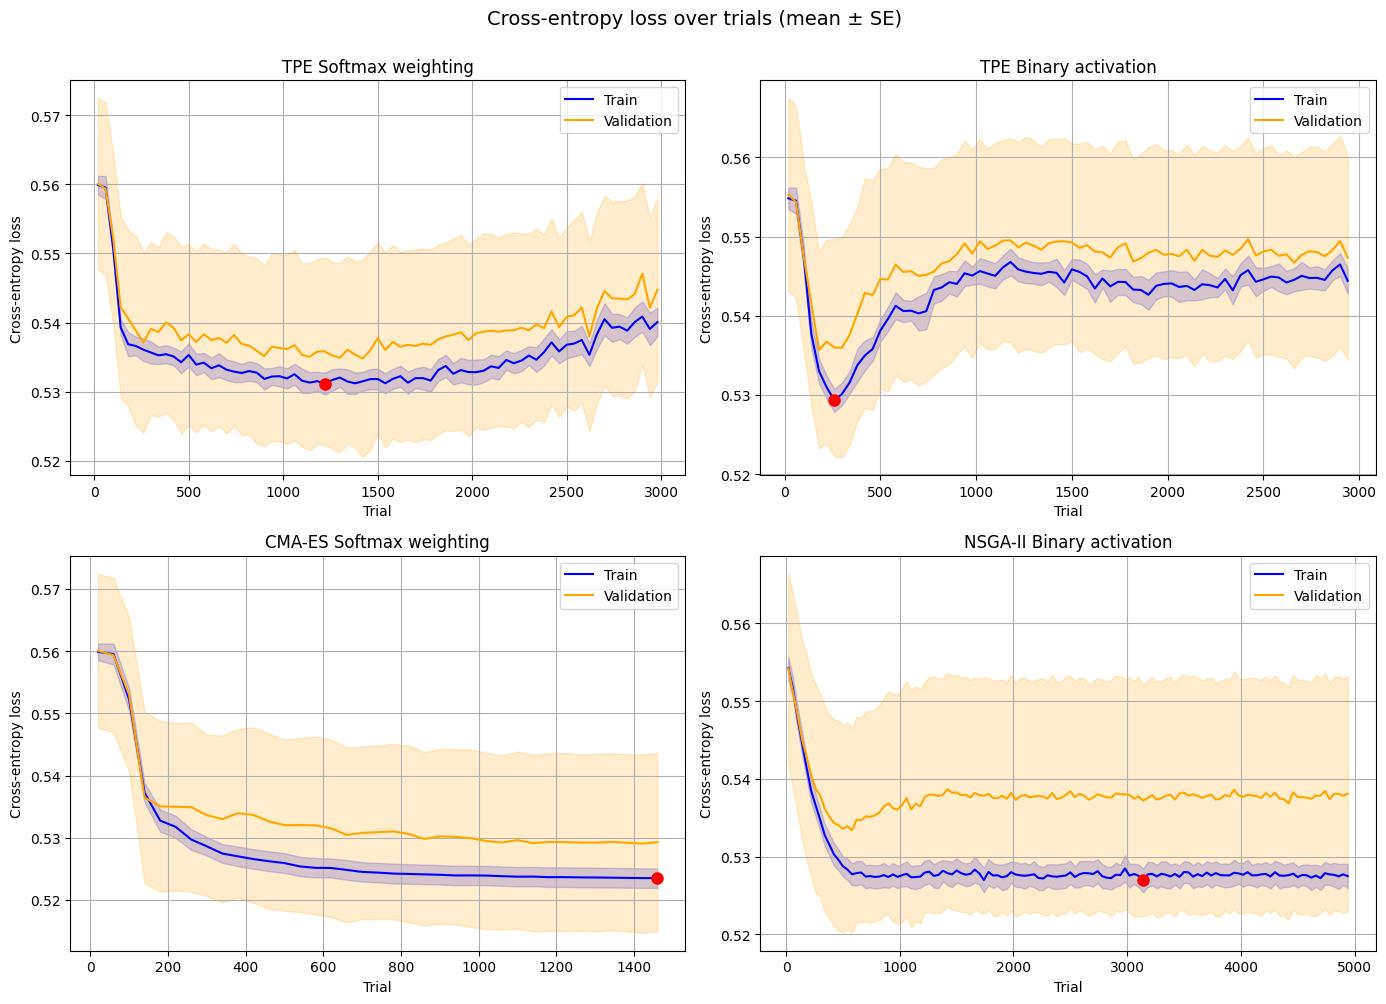

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
with open("cross_val_HPO_stats_2.pkl", "rb") as f:
    tracking_per_config = pickle.load(f)
k = 40  # bin size
configs = [
    ("TPE Softmax weighting", "Bayesian_Floating"),
    ("TPE Binary activation", "Bayesian_Binary"),
    ("CMA-ES Softmax weighting", "Genetic_Floating"),
    ("NSGA-II Binary activation", "Genetic_Binary"),
]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for idx, (label, config_key) in enumerate(configs):
    ax = axes[idx]
    tracking_list = tracking_per_config[config_key]
    n_folds = len(tracking_list)
    
    # Process both train and validation metrics
    for metric_type, metric_label, color in [
        ("opt_metrics", "Train", "blue"),
        ("test_metrics", "Validation", "orange")
    ]:
        per_fold_bins = []
        max_bins = 0
        
        # --- Per fold processing ---
        for tracking in tracking_list:
            hist = np.array(tracking[metric_type]["log_loss"])
            
            if len(hist) == 0:
                continue  # fully pruned fold
            
            n_bins = len(hist) // k
            if n_bins == 0:
                continue
            
            hist_b = (
                hist[:n_bins * k]
                .reshape(n_bins, k)
                .mean(axis=1)
            )
            per_fold_bins.append(hist_b)
            max_bins = max(max_bins, len(hist_b))
        
        padded = np.full((len(per_fold_bins), max_bins), np.nan)
        for i, fold_bins in enumerate(per_fold_bins):
            padded[i, :len(fold_bins)] = fold_bins
        
        n_eff = np.sum(~np.isnan(padded), axis=0)
        
        valid = n_eff == n_folds
        padded = padded[:, valid]
        
        mean = np.mean(padded, axis=0)
        std = np.std(padded, axis=0, ddof=1)
        ci = std / np.sqrt(n_folds)
        x = np.arange(len(mean)) * k + k // 2
        
        ax.plot(x, mean, label=metric_label, color=color)
        ax.fill_between(x, mean - ci, mean + ci, alpha=0.2, color=color)
        
        if len(mean) > 0 and metric_type=="opt_metrics":
            min_idx = np.argmin(mean)
            ax.plot(x[min_idx], mean[min_idx], 'ro', markersize=8, zorder=5)
    
    ax.set_xlabel("Trial")
    ax.set_ylabel("Cross-entropy loss")
    ax.set_title(label)
    ax.set_title(label)
    ax.legend()
    ax.grid(True)
plt.suptitle("Cross-entropy loss over trials (mean ± SE)", 
             fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Save results
import pickle
import os
os.makedirs(folder_to_save_metrics, exist_ok=True)

results_path = f"{folder_to_save_metrics}/optimization_results.pkl"
with open(results_path, "wb") as f:
    pickle.dump(tracking_vars, f)
    
print(f"Results saved to {results_path}")